# The moving average model: MA(q)

In [11]:
# this we use for implementing the MA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# how we simulate an MA Process - see how it works
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [12]:
plt.rcParams["figure.figsize"] = (9,6)

## Simulate a MA(1) process 

In [13]:
# the first coeff has to be 1 and the next is freely chooseable
ma1 = np.array([1, 0.9])

# this coeff cancel out the AR-portion and leaves us with a MA
ar1 = np.array([1, 0])

# 1000 timesteps
ma1_process = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

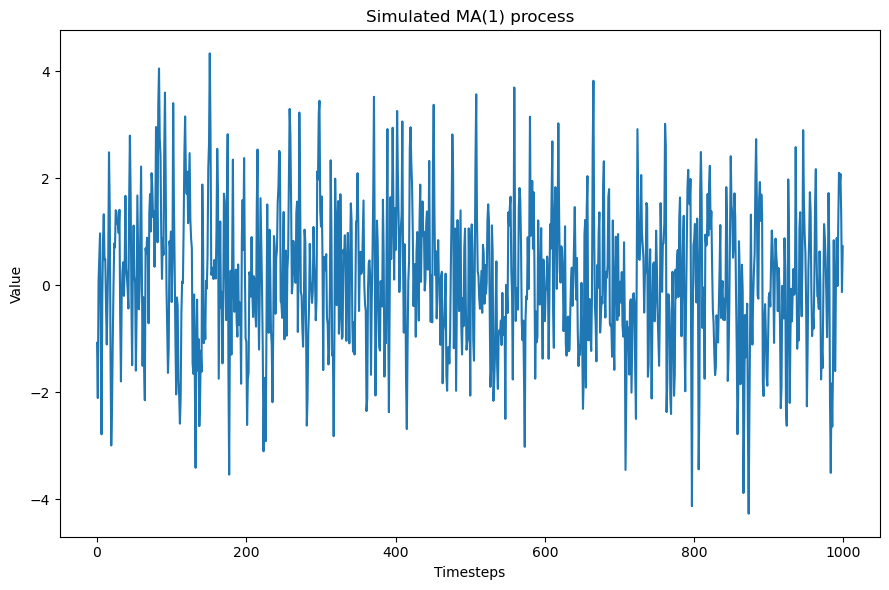

In [14]:
fig, ax = plt.subplots()

ax.plot(ma1_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.title('Simulated MA(1) process')

plt.tight_layout()

### 1) Is it stationary? 

- use ADF-Test

In [15]:
ADF_result = adfuller(ma1_process)

print(f"ADF statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF statistic: -8.073004051156204
p-value: 1.5316096082987785e-12


p-value < 0.05 - we reject H0 and can conclude that the process is stationary

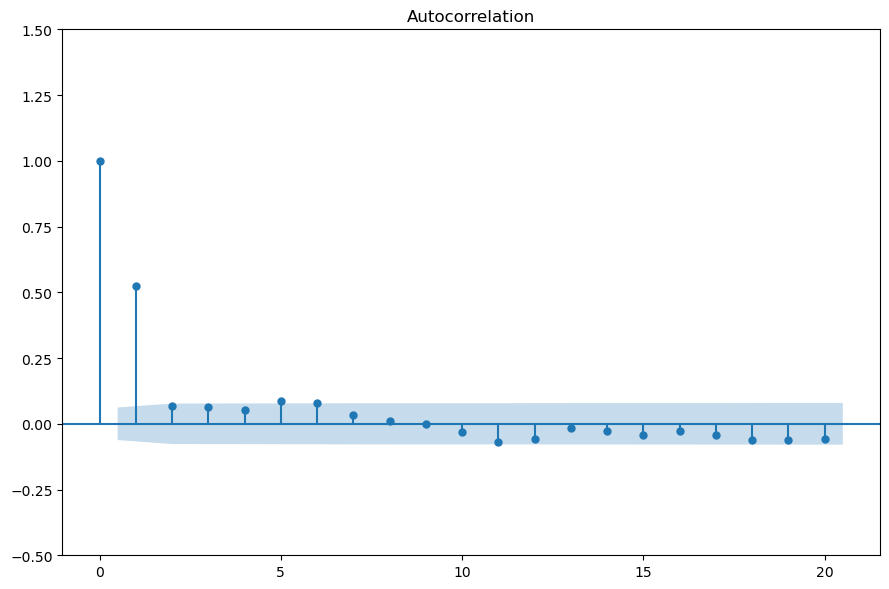

In [16]:
plot_acf(ma1_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with the MA(q) model 

Es ist selten möglich hiermit reale Daten zu modellieren - die brauchen bessere Modelle. Dieses ist sehr einfach!

In [17]:
df = pd.read_csv("data/simulated_MA3.csv")
df.head()

,value
0,50.000000
1,50.679213
2,51.771045
3,50.959927
4,52.162826


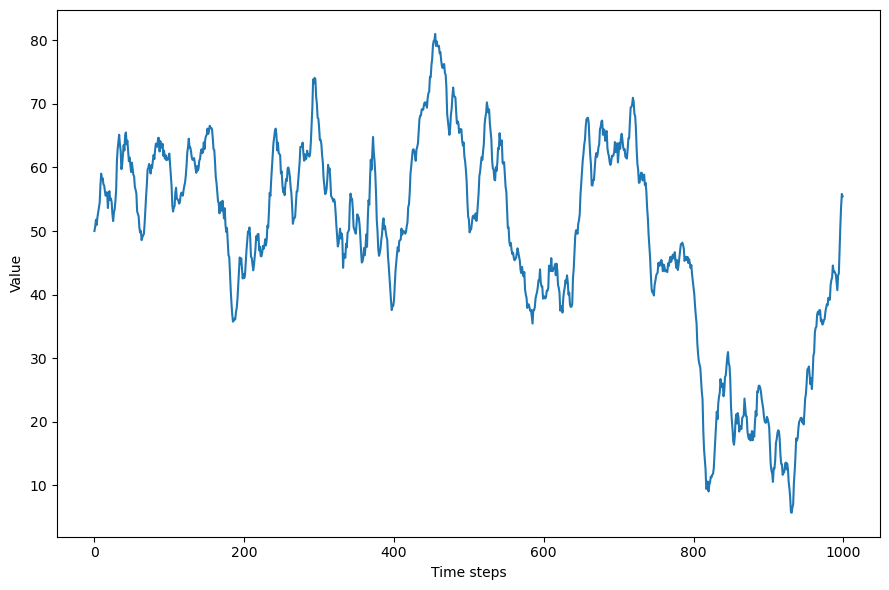

In [18]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### Test for stationarity 

In [19]:
ADF_result = adfuller(df["value"])

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: -2.4346611743907154
p-value: 0.13219152456766486


p > 0.05 - we failed to reject the H0 - the process is not stationary

In [20]:
# difference my series
# first order differencing
series_diff = np.diff(df["value"], n=1)

ADF_result = adfuller(series_diff)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: -6.149220026451252
p-value: 7.634171271237885e-08


p < 0.05 - we can reject the H0 - the process is stationary

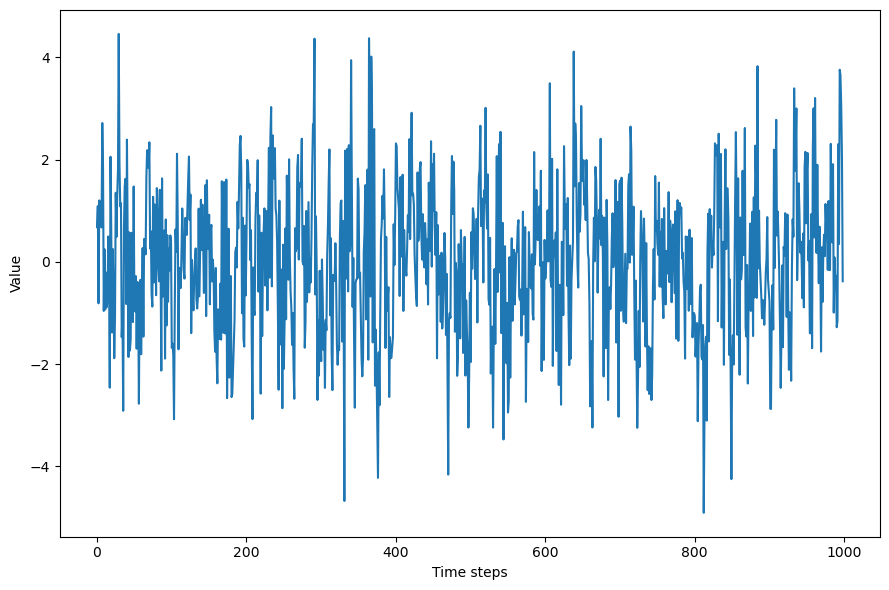

In [21]:
fig, ax = plt.subplots()

ax.plot(series_diff)
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### Plot ACF 

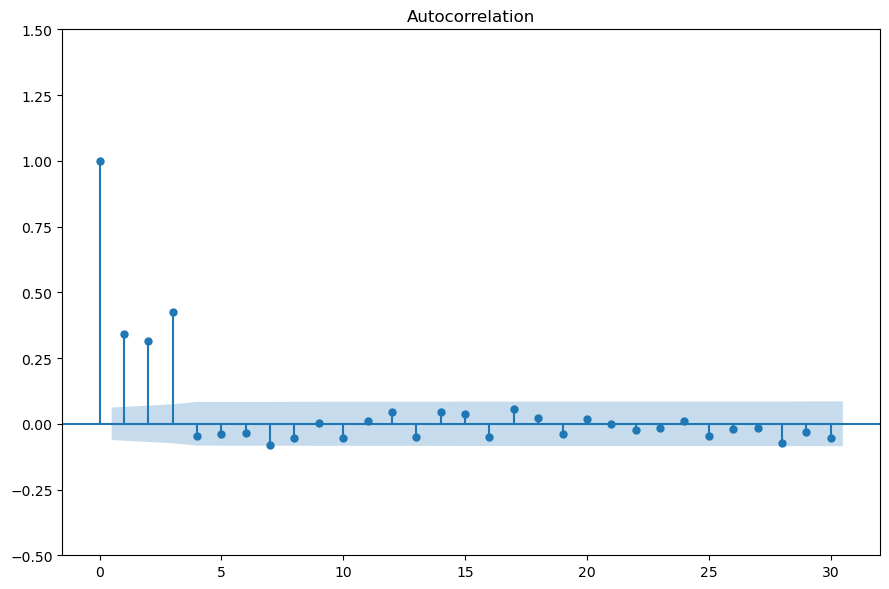

In [22]:
plot_acf(series_diff, lags=30);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

We have a moving average process of order 3.

In [23]:
type(series_diff)

numpy.ndarray

In [24]:
# split the data in train and test

df_diff = pd.DataFrame({"value": series_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(len(train))
print(len(test))

899
100


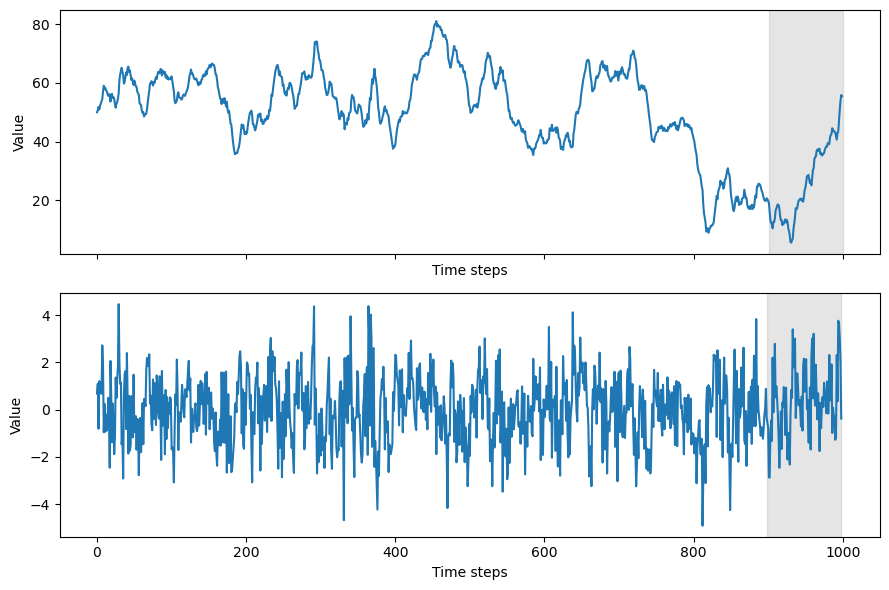

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['value'])
ax1.set_xlabel('Time steps')
ax1.set_ylabel('Value')
ax1.axvspan(901, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['value'])
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Value')
ax2.axvspan(899, 998, color='#808080', alpha=0.2)

plt.tight_layout()

! The first plot is the actual data and the second one the differenced one. The second one we are trying to predict!

## Write a function to make rolling predictions: 

In [50]:
i = TRAIN_LEN
last = df_diff.iloc[i].values[0]
print("Last 1: ", last)
last = df_diff[:i].iloc[-1].values[0]
#last = df_diff[:i].iloc[-1]
print("Last 2: ", last)

Last 1:  -0.5496801325333394
Last 2:  -0.34680883119116146


In [41]:
def rolling_predictions(
    df_diff: pd.DataFrame,
    last_train_value: int | float,
    train_len: int,
    horizon: int,
    window: int,
    method: str,
) -> list:
    """_summary_

    Args:
        df_diff (DataFrame): _description_
        last_train_value (int | float): needed to reverse the transformation of differncing
        train_len (int):
        horizon (int): length of test set - we want to predict
        window (int): number of timesteps that we predict at a time
        method (str): e.g. baseline like mean, last value

    Returns:
        pred_... (list): depends on method
    """
    TOTAL_LEN = train_len + horizon

    if method == "mean":
        pred_mean = []

        # im Bereich des Testsets e.g. von 100 bis 150 - davon wird z.b. immer von window =5 Werten der bewegende Abschnitt berechnet
        # i wäre dann 100, 105, 110...
        for i in range(train_len, TOTAL_LEN, window):
            # ! die Werte werden immer mehr pro Schleifendurchlauf
            # mean of training length
            mean = np.mean(df_diff[:i].values)
            # adds all the elements of an iterable (list, tuple, string etc.) to the end of the list
            # bei .append würde das Element selber übertragen werden also z.b. [3,4,[1,2]] nicht [3,4,1,2]
            # _ is a purely visual point to demonstrate to future developers that the value of the iterator is not used within the loop,
            # and it is purely for running the same code a set number of times. Therefore if there is a bug in the loop code, it is not related to the value of the iterator.

            # der oben berechnete Wert für e.g. die ersten 100 Elemente würde hier e.g. 5 (window) mal zu pred_mean hinzugefügt werden
            pred_mean.extend(mean for _ in range(window))
            
        # axis=0 is default - wird der Wert einfach nur vorne angehangen?
        pred_mean = np.concatenate((last_train_value, pred_mean))
        #print(pred_mean)
        # cumsum ist das Gegentail von diff -1 -> am Anfang steht last_train_value und auf den werden alle "Änderungen" aufaddiert
        pred_mean = pred_mean.cumsum()  # reverse the differencing

        return pred_mean[:100]  # that is the testing period we are interesting in

    elif method == "last":
        pred_last = []

        for i in range(train_len, TOTAL_LEN, window):
            last = df_diff.iloc[i]
           # print("Last 1: ", last)
           #? ist das nicht falsch? i ist nicht mehr enthalten!
            last = df_diff[:i].iloc[-1].values[0]
           # print("Last 2: ", last)

            pred_last.extend(last for _ in range(window))

        pred_last = np.concatenate((last_train_value, pred_last))
        pred_last = pred_last.cumsum()
        return pred_last[:100]
    
    elif method == "MA":
        pred_MA = []

        for i in range(train_len, TOTAL_LEN, window):
            # MA with order 3
            model = SARIMAX(df_diff[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            # oos = out of sample
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        pred_MA = np.concatenate((last_train_value, pred_MA))
        pred_MA = pred_MA.cumsum()
        return pred_MA[:100]

In [31]:
print(df.shape)
df.head()

(1000, 1)


,value
0,50.000000
1,50.679213
2,51.771045
3,50.959927
4,52.162826


In [42]:
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[899]

# try to fit different models and see how they are effected by window length
windows = [1, 2, 5, 10]


for window in windows:
    pred_mean = rolling_predictions(
        df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, "mean"
    )
    pred_last = rolling_predictions(
        df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, "last"
    )
    pred_MA = rolling_predictions(
        df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, "MA"
    )

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_MA_{window}'] = pred_MA

pred_df.head()

[ 2.04248146e+01 -3.28978703e-02 -3.34720728e-02 -3.42978504e-02
 -3.74431003e-02 -4.05897921e-02 -4.16812401e-02 -4.21394114e-02
 -4.35540286e-02 -4.10865325e-02 -4.11723074e-02 -3.96944179e-02
 -3.65956364e-02 -3.59897278e-02 -3.48702151e-02 -3.43233453e-02
 -3.44827969e-02 -3.57372649e-02 -3.83904105e-02 -3.99283978e-02
 -3.99622269e-02 -4.17362685e-02 -4.13715186e-02 -4.11898885e-02
 -4.01109463e-02 -3.94547259e-02 -4.05769230e-02 -3.95315260e-02
 -4.03539898e-02 -4.25896568e-02 -4.36083462e-02 -4.50640511e-02
 -4.75174739e-02 -4.76032832e-02 -4.66599069e-02 -4.60797899e-02
 -4.23949755e-02 -4.04441802e-02 -3.80598268e-02 -3.48137383e-02
 -3.51576916e-02 -3.46738162e-02 -3.30000635e-02 -3.18704619e-02
 -3.16409244e-02 -3.11901373e-02 -3.11152641e-02 -3.18352956e-02
 -3.12163673e-02 -3.21235880e-02 -3.01239683e-02 -2.78236943e-02
 -2.70001073e-02 -2.51080554e-02 -2.28433067e-02 -2.27897123e-02
 -2.23341548e-02 -2.37694578e-02 -2.52079335e-02 -2.42022211e-02
 -2.59402237e-02 -2.35856

,value,pred_mean_1,pred_last_1,pred_MA_1,pred_mean_2,pred_last_2,pred_MA_2,pred_mean_5,pred_last_5,pred_MA_5,pred_mean_10,pred_last_10,pred_MA_10
900,19.875135,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815
901,19.097637,20.391917,20.078006,21.504889,20.391917,20.078006,21.504889,20.391917,20.078006,21.504889,20.391917,20.078006,21.504889
902,16.226323,20.358445,19.528326,21.219126,20.359019,19.731197,21.617295,20.359019,19.731197,21.617295,20.359019,19.731197,21.617295
903,13.347418,20.324147,18.750828,19.472224,20.324721,18.953699,19.870393,20.326121,19.384388,20.663187,20.326121,19.384388,20.663187
904,12.320159,20.286704,15.879515,17.596160,20.290423,18.176202,18.268595,20.293223,19.037579,20.663187,20.293223,19.037579,20.663187


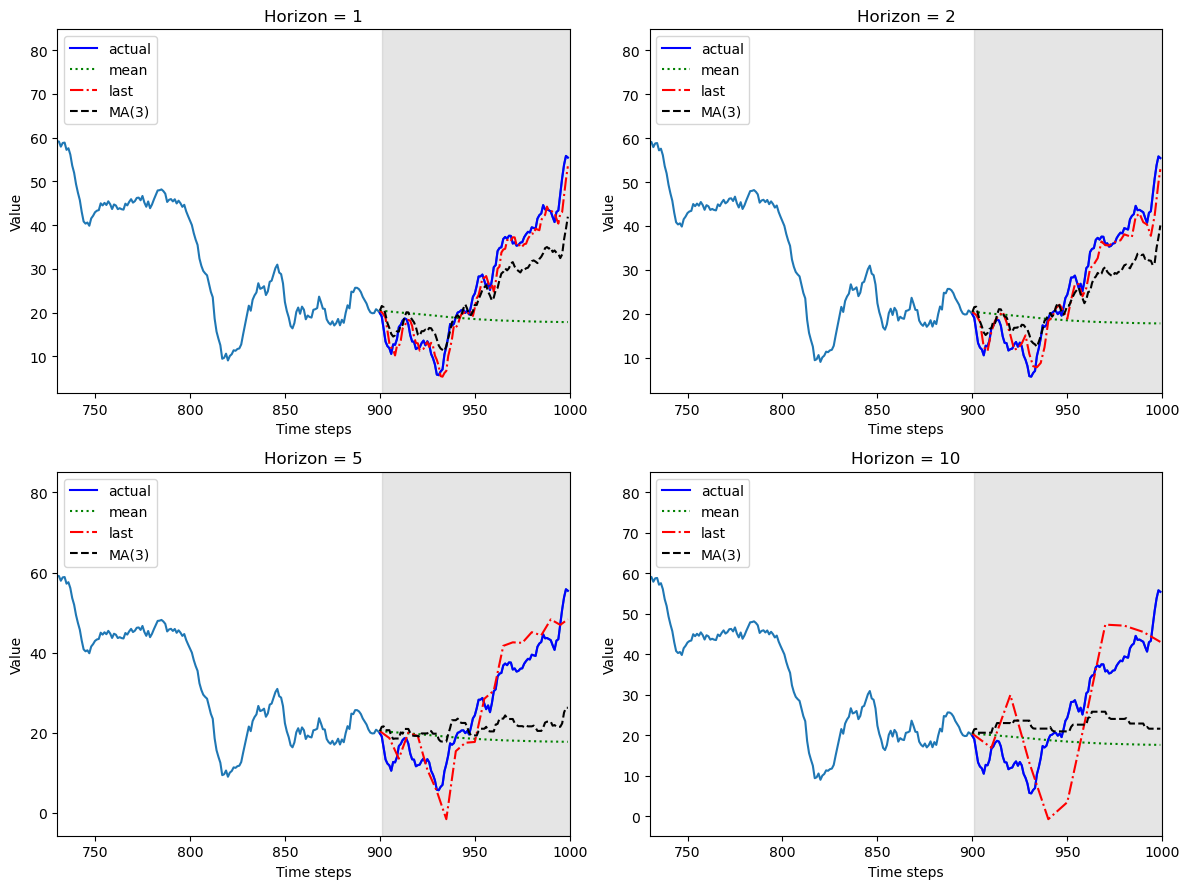

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_MA_{windows[i]}'], 'k--', label='MA(3)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(901, 1000, color='#808080', alpha=0.2)
    ax.set_xlim(730, 1000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [44]:
from sklearn.metrics import mean_absolute_error

mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_MA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_MA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_MA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_MA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_10'])

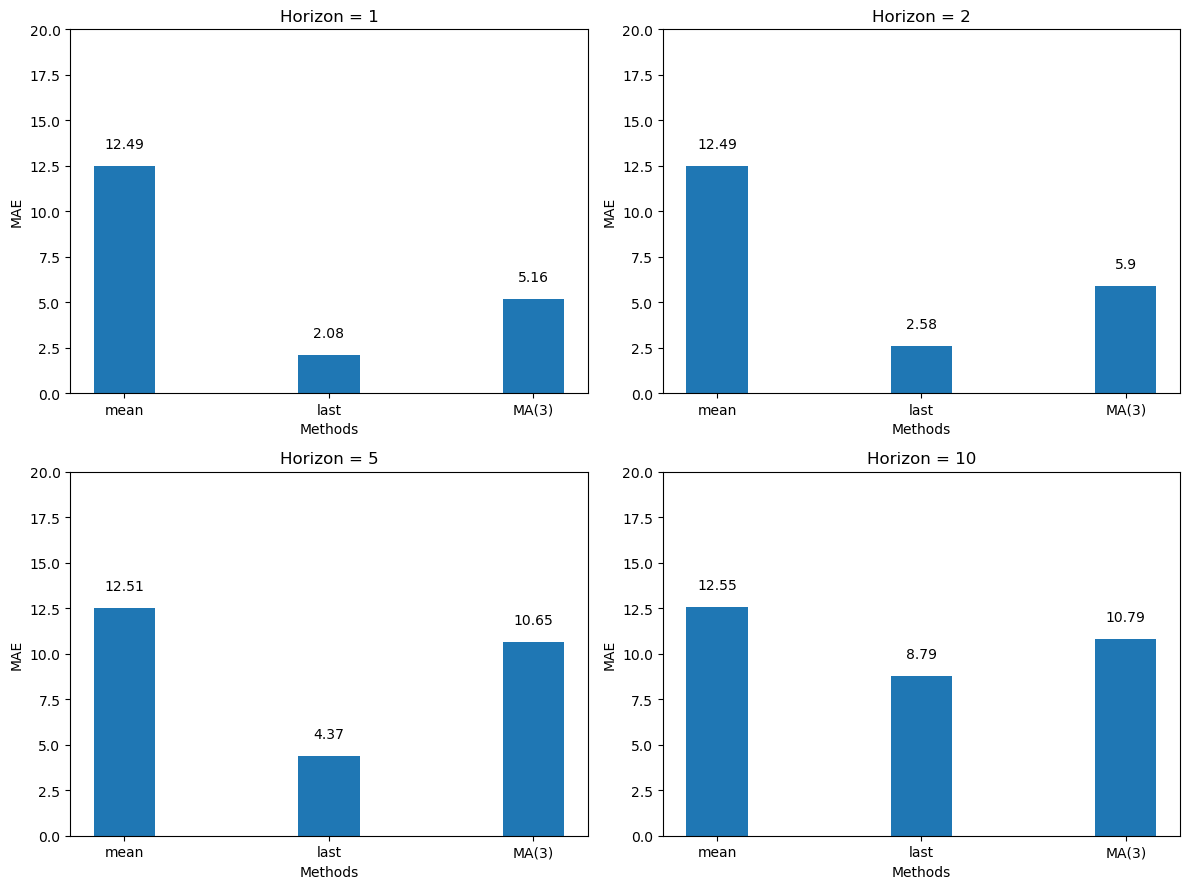

In [45]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_MA = [mae_MA_1, mae_MA_2, mae_MA_5, mae_MA_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'MA(3)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_MA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 20)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()